In [ ]:
#import dependencies
import keras
from keras.models import Sequential
from keras import utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers, optimizers
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Feb  6 03:59:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
# Download dataset from Google Drive
! gdown --id 1ZdK5f5rbR4E7rzzAIXm84L8Mjp9HCfS0

# Links

# Zero Pad 128: 1-9hnSKSnqQmELI5_PAPy9BhLDc-bKEbE

# White Pad 128: 1ZdK5f5rbR4E7rzzAIXm84L8Mjp9HCfS0

# Zero Pad 224: 1-9sy-KxqUqBsW-GcsvfThzQL-0QiMfBS

# White Pad 224: 1-6ekgyym3PYND6Z9oRlVo8sE5XV8B_km

# Zero Pad 512: 1-DYICH8IyqrQh--WprRTrpYDzS-QgUc0

# White Pad 512: 1-AmotnWWdvKNxYlkGCS4BkrLY1BnrnaU

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ZdK5f5rbR4E7rzzAIXm84L8Mjp9HCfS0
From (redirected): https://drive.google.com/uc?id=1ZdK5f5rbR4E7rzzAIXm84L8Mjp9HCfS0&confirm=t&uuid=e8a40472-05b0-4a1f-868b-186c80b41e63
To: /content/White_Pad_128.zip
100% 209M/209M [00:02<00:00, 99.1MB/s]


In [ ]:
! mkdir data
!unzip White_Pad_128.zip

Streaming output truncated to the last 5000 lines.
 extracting: content/white_pad_128/1_Sclerotic/S-1909-007195_PAS_2of2_647582c3435c92704a444147.png  
  inflating: content/white_pad_128/1_Sclerotic/S-2006-001849_PAS_1of2_64542f6e435c92704a3575ff.png  
  inflating: content/white_pad_128/1_Sclerotic/S-1910-000090_PAS_1of2_64551d4e435c92704a3d0f4c.png  
  inflating: content/white_pad_128/1_Sclerotic/S-2102-006457_PAS_2of2_645527ff435c92704a3ef449.png  
  inflating: content/white_pad_128/1_Sclerotic/S-2010-013043_PAS_1of2_64552795435c92704a3e03c2.png  
  inflating: content/white_pad_128/1_Sclerotic/S-2006-003978_PAS_2of2_645432e3435c92704a38b27a.png  
  inflating: content/white_pad_128/1_Sclerotic/S-1908-009734_PAS_2of2_64551cdf435c92704a3c452b.png  
  inflating: content/white_pad_128/1_Sclerotic/S-2102-006457_PAS_2of2_645527ff435c92704a3ef441.png  
 extracting: content/white_pad_128/1_Sclerotic/S-2103-004716_PAS_2of2_64552857435c92704a3faeb0.png  
  inflating: content/white_pad_128/1_Scl

In [ ]:
! mv content/* data

In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/data/white_pad_128', output="output", seed=1345, ratio=(0.8, 0.1,0.1))

Copying files: 5758 files [00:01, 5085.94 files/s]


In [ ]:
from PIL import Image
import os

# Specify the paths to your train, val, and test folders containing your PNG images
train_folder = "/content/output/train"
val_folder = "/content/output/val"
test_folder = "/content/output/test"

def load_images_and_labels(folder_path):
    x_data = []
    y_data = []

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            label = int(subfolder.split('_')[0])  # Assuming the folder names are 0 or 1

            for image_name in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_name)

                # Open image and convert to numpy array
                img = Image.open(image_path)
                img_array = np.array(img)

                # Append data to arrays
                x_data.append(img_array)
                y_data.append(label)

    return np.array(x_data), np.array(y_data)

# Load train data
x_train, y_train = load_images_and_labels(train_folder)

# Load validation data
x_val, y_val = load_images_and_labels(val_folder)

# Load test data
x_test, y_test = load_images_and_labels(test_folder)

# Now, x_train, y_train, x_val, y_val, x_test, y_test contain your image data and labels in NumPy arrays.

# Print the shape of the resulting array
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of x_train: (4606, 128, 128, 3)
Shape of y_train: (4606,)
Shape of x_val: (575, 128, 128, 3)
Shape of y_val: (575,)
Shape of x_test: (577, 128, 128, 3)
Shape of y_test: (577,)


In [ ]:
# Normalize the data to speed up training
mean = np.mean(x_train)
std = np.std(x_train)
x_train = (x_train-mean)/(std+1e-7)
x_val = (x_val-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

# let's look at the normalized values of a sample image
x_train[0]

array([[[1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792],
        ...,
        [1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792]],

       [[1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792],
        ...,
        [1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792]],

       [[1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792],
        ...,
        [1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792]],

       ...,

       [[1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1

In [ ]:
# let's display the labels
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
# Model 1: 1 Output layer No Hidden Layers

# build the model

# instantiate an empty sequential model
model1 = Sequential()
model1.add(Flatten(input_shape=x_train.shape[1:]))
model1.add(Dense(1, activation='sigmoid'))

# print model summary
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 1)                 49153     
                                                                 
Total params: 49153 (192.00 KB)
Trainable params: 49153 (192.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Model 2: 1 Hidden Dense layer 512 neurons

# build the model

# instantiate an empty sequential model
model2 = Sequential()
model2.add(Flatten(input_shape=x_train.shape[1:]))
model2.add(Dense(512, activation = 'relu'))
model2.add(Dense(1, activation='sigmoid'))

# print model summary
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 49152)             0         
                                                                 
 dense_1 (Dense)             (None, 512)               25166336  
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 25166849 (96.00 MB)
Trainable params: 25166849 (96.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Model 3: 1 Hidden Dense layer 64 neurons

# build the model

# instantiate an empty sequential model
model3 = Sequential()
model3.add(Flatten(input_shape=x_train.shape[1:]))
model3.add(Dense(64, activation = 'relu'))
model3.add(Dense(1, activation='sigmoid'))

# print model summary
model3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 49152)             0         
                                                                 
 dense_3 (Dense)             (None, 64)                3145792   
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3145857 (12.00 MB)
Trainable params: 3145857 (12.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Model 4: 2 Hidden Dense layers 512, 512 neurons

# build the model

# instantiate an empty sequential model
model4 = Sequential()
model4.add(Flatten(input_shape=x_train.shape[1:]))
model4.add(Dense(512, activation = 'relu'))
model4.add(Dense(512, activation = 'relu'))
model4.add(Dense(1, activation='sigmoid'))

# print model summary
model4.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 49152)             0         
                                                                 
 dense_5 (Dense)             (None, 512)               25166336  
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 25429505 (97.01 MB)
Trainable params: 25429505 (97.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# CNN model 1: 1 CNN layer and 2 Hidden Dense layers 512, 512 neurons

# build the model

# number of hidden units variable
base_hidden_units = 16

# l2 regularization hyperparameter
weight_decay = 1e-4

# instantiate an empty sequential model
model5 = Sequential()

# CONV1
model5.add(Conv2D(base_hidden_units, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))

# FCN
model5.add(Flatten())
model5.add(Dense(512, activation = 'relu'))
model5.add(Dense(512, activation = 'relu'))
model5.add(Dense(1, activation='sigmoid'))

# print model summary
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                                 
 dense (Dense)               (None, 512)               134218240 
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 134481857 (513.01 MB)
Trainable params: 134481857 (513.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# CNN model 2: 1 CNN layer and 3 Hidden Dense layers 512, 512, 64 neurons

# build the model

# number of hidden units variable
base_hidden_units = 16

# l2 regularization hyperparameter
weight_decay = 1e-4

# instantiate an empty sequential model
model6 = Sequential()

# CONV1
model6.add(Conv2D(base_hidden_units, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))

# FCN

model6.add(Flatten())
model6.add(Dense(512, activation = 'relu'))
model6.add(Dense(512, activation = 'relu'))
model6.add(Dense(64, activation = 'relu'))
model6.add(Dense(1, activation='sigmoid'))

# print model summary
model6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 flatten_1 (Flatten)         (None, 262144)            0         
                                                                 
 dense_3 (Dense)             (None, 512)               134218240 
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 134514241 (513.13 MB)
Trainable params: 

In [ ]:
# CNN model 3: 2 CNN layers and 3 Hidden Dense layers 512, 512, 64 neurons

# build the model

# number of hidden units variable
base_hidden_units = 16

# l2 regularization hyperparameter
weight_decay = 1e-4

# instantiate an empty sequential model
model7 = Sequential()

# CONV1
model7.add(Conv2D(base_hidden_units, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))

# CONV2
model7.add(Conv2D(2*base_hidden_units, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))

# FCN

model7.add(Flatten())
model7.add(Dense(512, activation = 'relu'))
model7.add(Dense(512, activation = 'relu'))
model7.add(Dense(64, activation = 'relu'))
model7.add(Dense(1, activation='sigmoid'))

# print model summary
model7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 flatten (Flatten)           (None, 524288)            0         
                                                                 
 dense (Dense)               (None, 512)               268435968 
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dense_3 (Dense)             (None, 1)                 6

In [ ]:
# CNN model 4: 2 CNN layers with BatchNormalization and 3 Hidden Dense layers 512, 512, 64 neurons

# build the model

# number of hidden units variable
base_hidden_units = 16

# l2 regularization hyperparameter
weight_decay = 1e-4

# instantiate an empty sequential model
model8 = Sequential()

# CONV1
model8.add(Conv2D(base_hidden_units, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model8.add(BatchNormalization())
# CONV2
model8.add(Conv2D(2*base_hidden_units, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model8.add(BatchNormalization())

# FCN

model8.add(Flatten())
model8.add(Dense(512, activation = 'relu'))
model8.add(BatchNormalization())
model8.add(Dense(512, activation = 'relu'))
model8.add(BatchNormalization())
model8.add(Dense(64, activation = 'relu'))
model8.add(BatchNormalization())
model8.add(Dense(1, activation='sigmoid'))

# print model summary
model8.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 524288)            0         
                                                                 
 dense_4 (Dense)             (None, 512)              

In [ ]:
# CNN model 5: 2 CNN layers with MaxPooling2D and BatchNormalization and 3 Hidden Dense layers 512, 512, 64 neurons

# build the model

# number of hidden units variable
base_hidden_units = 16

# l2 regularization hyperparameter
weight_decay = 1e-4

# instantiate an empty sequential model
model9 = Sequential()

# CONV1
model9.add(Conv2D(base_hidden_units, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model9.add(BatchNormalization())
model9.add(MaxPooling2D(pool_size=(2,2)))
# CONV2
model9.add(Conv2D(2*base_hidden_units, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model9.add(BatchNormalization())
model9.add(MaxPooling2D(pool_size=(2,2)))

# FCN

model9.add(Flatten())
model9.add(Dense(512, activation = 'relu'))
model9.add(BatchNormalization())
model9.add(Dense(512, activation = 'relu'))
model9.add(BatchNormalization())
model9.add(Dense(64, activation = 'relu'))
model9.add(BatchNormalization())
model9.add(Dense(1, activation='sigmoid'))

# print model summary
model9.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                        

In [ ]:
# CNN model 6: 2 CNN layers with BatchNormalization and Dropout, but NO MaxPooling2D, and 3 Hidden Dense layers 512, 512, 64 neurons

# build the model

# number of hidden units variable
base_hidden_units = 16

# l2 regularization hyperparameter
weight_decay = 1e-4

# instantiate an empty sequential model
model10 = Sequential()

# CONV1
model10.add(Conv2D(base_hidden_units, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model10.add(BatchNormalization())
#model10.add(MaxPooling2D(pool_size=(2,2)))

# CONV2
model10.add(Conv2D(2*base_hidden_units, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model10.add(BatchNormalization())
#model10.add(MaxPooling2D(pool_size=(2,2)))

# FCN

model10.add(Flatten())
model10.add(Dense(512, activation = 'relu'))
model10.add(BatchNormalization())
model10.add(Dropout(0.2))
model10.add(Dense(512, activation = 'relu'))
model10.add(BatchNormalization())
model10.add(Dropout(0.2))
model10.add(Dense(64, activation = 'relu'))
model10.add(BatchNormalization())
model10.add(Dropout(0.2))
model10.add(Dense(1, activation='sigmoid'))

# print model summary
model10.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 batch_normalization_5 (Bat  (None, 128, 128, 16)      64        
 chNormalization)                                                
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 batch_normalization_6 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 524288)            0         
                                                                 
 dense_4 (Dense)             (None, 512)              

In [ ]:
# CNN model 7: 2 CNN layers with BatchNormalization, Dropout and ONLY 2 Hidden Dense layers 512, 512, 64 neurons
# (after model8, remove one dense layer to reduce overfitting)

# build the model

# number of hidden units variable
base_hidden_units = 16

# l2 regularization hyperparameter
weight_decay = 1e-4

# instantiate an empty sequential model
model11 = Sequential()

# CONV1
model11.add(Conv2D(base_hidden_units, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model11.add(BatchNormalization())
#model11.add(MaxPooling2D(pool_size=(2,2)))

# CONV2
model11.add(Conv2D(2*base_hidden_units, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model11.add(BatchNormalization())
#model11.add(MaxPooling2D(pool_size=(2,2)))

# FCN

model11.add(Flatten())
model11.add(Dense(512, activation = 'relu'))
model11.add(BatchNormalization())
model11.add(Dropout(0.2))
model11.add(Dense(64, activation = 'relu'))
model11.add(BatchNormalization())
model11.add(Dropout(0.2))
model11.add(Dense(1, activation='sigmoid'))

# print model summary
model11.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 batch_normalization_10 (Ba  (None, 128, 128, 16)      64        
 tchNormalization)                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 batch_normalization_11 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 flatten_2 (Flatten)         (None, 524288)            0         
                                                                 
 dense_8 (Dense)             (None, 512)              

In [ ]:
# CNN model 8: 2 CNN layers with BatchNormalization, Dropout and ONLY 2 Hidden Dense layers 512, 512, 64 neurons
# Plus MaxPooling
# (after model8, remove one dense layer to reduce overfitting)

# build the model

# number of hidden units variable
base_hidden_units = 16

# l2 regularization hyperparameter
weight_decay = 1e-4

# instantiate an empty sequential model
model12 = Sequential()

# CONV1
model12.add(Conv2D(base_hidden_units, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model12.add(BatchNormalization())
model12.add(MaxPooling2D(pool_size=(2,2)))

# CONV2
model12.add(Conv2D(2*base_hidden_units, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model12.add(BatchNormalization())
model12.add(MaxPooling2D(pool_size=(2,2)))

# FCN

model12.add(Flatten())
model12.add(Dense(512, activation = 'relu'))
model12.add(BatchNormalization())
model12.add(Dropout(0.2))
model12.add(Dense(64, activation = 'relu'))
model12.add(BatchNormalization())
model12.add(Dropout(0.2))
model12.add(Dense(1, activation='sigmoid'))

# print model summary
model12.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 batch_normalization_14 (Ba  (None, 128, 128, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 batch_normalization_15 (Ba  (None, 64, 64, 32)        128       
 tchNormalization)                                               
                                                      

In [ ]:
# data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )

# compute the data augmentation on the training set
datagen.fit(x_train)

In [ ]:
# training
batch_size = 64
epochs=60

optimizer1 = keras.optimizers.Adam(learning_rate=0.0001)
optimizer2 = keras.optimizers.Adam(learning_rate=0.0001)
optimizer3 = keras.optimizers.Adam(learning_rate=0.0001)
optimizer4 = keras.optimizers.Adam(learning_rate=0.0001)
optimizer5 = keras.optimizers.Adam(learning_rate=0.0001)
optimizer6 = keras.optimizers.Adam(learning_rate=0.0001)
optimizer7 = keras.optimizers.Adam(learning_rate=0.0001)
optimizer8 = keras.optimizers.Adam(learning_rate=0.0001)
optimizer9 = keras.optimizers.Adam(learning_rate=0.0001)
optimizer10 = keras.optimizers.Adam(learning_rate=0.0001)
optimizer11 = keras.optimizers.Adam(learning_rate=0.0001)
optimizer12 = keras.optimizers.Adam(learning_rate=0.0001)



model1.compile(loss='binary_crossentropy', optimizer=optimizer1, metrics=['accuracy'])

model2.compile(loss='binary_crossentropy', optimizer=optimizer2, metrics=['accuracy'])

model3.compile(loss='binary_crossentropy', optimizer=optimizer3, metrics=['accuracy'])

model4.compile(loss='binary_crossentropy', optimizer=optimizer4, metrics=['accuracy'])

model5.compile(loss='binary_crossentropy', optimizer=optimizer5, metrics=['accuracy'])

model6.compile(loss='binary_crossentropy', optimizer=optimizer6, metrics=['accuracy'])

model7.compile(loss='binary_crossentropy', optimizer=optimizer7, metrics=['accuracy'])

model8.compile(loss='binary_crossentropy', optimizer=optimizer8, metrics=['accuracy'])

model9.compile(loss='binary_crossentropy', optimizer=optimizer9, metrics=['accuracy'])

model10.compile(loss='binary_crossentropy', optimizer=optimizer10, metrics=['accuracy'])

model11.compile(loss='binary_crossentropy', optimizer=optimizer11, metrics=['accuracy'])

model12.compile(loss='binary_crossentropy', optimizer=optimizer12, metrics=['accuracy'])

In [ ]:
history1 = model1.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,
                validation_data=(x_val,y_val))

<ipython-input-14-ea7849501559>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model1.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/50
71/71 [==============================] - 18s 237ms/step - loss: 0.5312 - accuracy: 0.7752 - val_loss: 0.4868 - val_accuracy: 0.7983
Epoch 2/50
71/71 [==============================] - 16s 229ms/step - loss: 0.4417 - accuracy: 0.8096 - val_loss: 0.4531 - val_accuracy: 0.8261
Epoch 3/50
71/71 [==============================] - 17s 240ms/step - loss: 0.3936 - accuracy: 0.8307 - val_loss: 0.3968 - val_accuracy: 0.8452
Epoch 4/50
71/71 [==============================] - 17s 236ms/step - loss: 0.3693 - accuracy: 0.8437 - val_loss: 0.3615 - val_accuracy: 0.8504
Epoch 5/50
71/71 [==============================] - 16s 224ms/step - loss: 0.3483 - accuracy: 0.8545 - val_loss: 0.3300 - val_accuracy: 0.8609
Epoch 6/50
71/71 [==============================] - 27s 385ms/step - loss: 0.3281 - accuracy: 0.8644 - val_loss: 0.3269 - val_accuracy: 0.8765
Epoch 7/50
71/71 [==============================] - 16s 225ms/step - loss: 0.3174 - accuracy: 0.8675 - val_loss: 0.3027 - val_accuracy: 0.8852

In [ ]:
history2 = model2.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,
                validation_data=(x_val,y_val))

<ipython-input-17-670e8a2566a0>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model2.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/50
71/71 [==============================] - 19s 245ms/step - loss: 0.5929 - accuracy: 0.7988 - val_loss: 0.4403 - val_accuracy: 0.8087
Epoch 2/50
71/71 [==============================] - 16s 231ms/step - loss: 0.4208 - accuracy: 0.8223 - val_loss: 0.3969 - val_accuracy: 0.8400
Epoch 3/50
71/71 [==============================] - 16s 228ms/step - loss: 0.3924 - accuracy: 0.8292 - val_loss: 0.3392 - val_accuracy: 0.8504
Epoch 4/50
71/71 [==============================] - 18s 256ms/step - loss: 0.3463 - accuracy: 0.8545 - val_loss: 0.3202 - val_accuracy: 0.8574
Epoch 5/50
71/71 [==============================] - 17s 244ms/step - loss: 0.3440 - accuracy: 0.8542 - val_loss: 0.2999 - val_accuracy: 0.8748
Epoch 6/50
71/71 [==============================] - 16s 228ms/step - loss: 0.3189 - accuracy: 0.8655 - val_loss: 0.2941 - val_accuracy: 0.8696
Epoch 7/50
71/71 [==============================] - 17s 232ms/step - loss: 0.3104 - accuracy: 0.8710 - val_loss: 0.2860 - val_accuracy: 0.8870

In [ ]:
history3 = model3.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,
                validation_data=(x_val,y_val))

<ipython-input-20-2f1bbe5c72c1>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3 = model3.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/50
71/71 [==============================] - 17s 227ms/step - loss: 0.4773 - accuracy: 0.8056 - val_loss: 0.4148 - val_accuracy: 0.8296
Epoch 2/50
71/71 [==============================] - 17s 241ms/step - loss: 0.3897 - accuracy: 0.8344 - val_loss: 0.3861 - val_accuracy: 0.8539
Epoch 3/50
71/71 [==============================] - 16s 227ms/step - loss: 0.3845 - accuracy: 0.8415 - val_loss: 0.3674 - val_accuracy: 0.8522
Epoch 4/50
71/71 [==============================] - 17s 235ms/step - loss: 0.3601 - accuracy: 0.8507 - val_loss: 0.3258 - val_accuracy: 0.8730
Epoch 5/50
71/71 [==============================] - 17s 235ms/step - loss: 0.3411 - accuracy: 0.8516 - val_loss: 0.3319 - val_accuracy: 0.8557
Epoch 6/50
71/71 [==============================] - 16s 229ms/step - loss: 0.3230 - accuracy: 0.8642 - val_loss: 0.3033 - val_accuracy: 0.8713
Epoch 7/50
71/71 [==============================] - 16s 226ms/step - loss: 0.3195 - accuracy: 0.8659 - val_loss: 0.2981 - val_accuracy: 0.8661

In [ ]:
history4 = model4.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,
                validation_data=(x_val,y_val))

<ipython-input-23-c4151e0920ca>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history4 = model4.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/50
71/71 [==============================] - 19s 233ms/step - loss: 0.5235 - accuracy: 0.7996 - val_loss: 0.4146 - val_accuracy: 0.8296
Epoch 2/50
71/71 [==============================] - 19s 266ms/step - loss: 0.4084 - accuracy: 0.8338 - val_loss: 0.3638 - val_accuracy: 0.8417
Epoch 3/50
71/71 [==============================] - 16s 230ms/step - loss: 0.3688 - accuracy: 0.8505 - val_loss: 0.3231 - val_accuracy: 0.8748
Epoch 4/50
71/71 [==============================] - 17s 245ms/step - loss: 0.3485 - accuracy: 0.8487 - val_loss: 0.3399 - val_accuracy: 0.8435
Epoch 5/50
71/71 [==============================] - 16s 232ms/step - loss: 0.3532 - accuracy: 0.8525 - val_loss: 0.2804 - val_accuracy: 0.8783
Epoch 6/50
71/71 [==============================] - 20s 277ms/step - loss: 0.3141 - accuracy: 0.8692 - val_loss: 0.2562 - val_accuracy: 0.9009
Epoch 7/50
71/71 [==============================] - 16s 230ms/step - loss: 0.3188 - accuracy: 0.8691 - val_loss: 0.2629 - val_accuracy: 0.9148

In [ ]:
history5 = model5.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,
                validation_data=(x_val,y_val))

<ipython-input-14-e3a40d62650a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history5 = model5.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/50
71/71 [==============================] - 24s 279ms/step - loss: 0.5250 - accuracy: 0.8415 - val_loss: 0.2914 - val_accuracy: 0.8817
Epoch 2/50
71/71 [==============================] - 19s 270ms/step - loss: 0.2864 - accuracy: 0.8895 - val_loss: 0.2051 - val_accuracy: 0.9061
Epoch 3/50
71/71 [==============================] - 22s 314ms/step - loss: 0.2457 - accuracy: 0.9042 - val_loss: 0.3019 - val_accuracy: 0.8852
Epoch 4/50
71/71 [==============================] - 23s 331ms/step - loss: 0.2366 - accuracy: 0.9053 - val_loss: 0.2265 - val_accuracy: 0.9061
Epoch 5/50
71/71 [==============================] - 20s 288ms/step - loss: 0.2236 - accuracy: 0.9146 - val_loss: 0.2275 - val_accuracy: 0.9183
Epoch 6/50
71/71 [==============================] - 22s 302ms/step - loss: 0.1922 - accuracy: 0.9258 - val_loss: 0.1880 - val_accuracy: 0.9165
Epoch 7/50
71/71 [==============================] - 26s 367ms/step - loss: 0.1874 - accuracy: 0.9280 - val_loss: 0.1337 - val_accuracy: 0.9461

In [ ]:
history6 = model6.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,
                validation_data=(x_val,y_val))

<ipython-input-20-6f253cbcfbf3>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history6 = model6.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/60
71/71 [==============================] - 23s 295ms/step - loss: 0.3874 - accuracy: 0.8562 - val_loss: 0.3293 - val_accuracy: 0.8783
Epoch 2/60
71/71 [==============================] - 19s 266ms/step - loss: 0.2879 - accuracy: 0.8866 - val_loss: 0.2127 - val_accuracy: 0.9113
Epoch 3/60
71/71 [==============================] - 22s 304ms/step - loss: 0.2484 - accuracy: 0.8998 - val_loss: 0.1662 - val_accuracy: 0.9374
Epoch 4/60
71/71 [==============================] - 20s 278ms/step - loss: 0.2140 - accuracy: 0.9141 - val_loss: 0.1749 - val_accuracy: 0.9252
Epoch 5/60
71/71 [==============================] - 19s 265ms/step - loss: 0.2288 - accuracy: 0.9133 - val_loss: 0.2886 - val_accuracy: 0.8887
Epoch 6/60
71/71 [==============================] - 21s 289ms/step - loss: 0.2307 - accuracy: 0.9111 - val_loss: 0.1563 - val_accuracy: 0.9391
Epoch 7/60
71/71 [==============================] - 21s 299ms/step - loss: 0.1842 - accuracy: 0.9295 - val_loss: 0.1504 - val_accuracy: 0.9391

In [ ]:
history7 = model7.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,
                validation_data=(x_val,y_val))

<ipython-input-16-69863e40b2ac>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history7 = model7.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/60
71/71 [==============================] - 30s 346ms/step - loss: 0.4059 - accuracy: 0.8595 - val_loss: 0.1947 - val_accuracy: 0.9304
Epoch 2/60
71/71 [==============================] - 22s 312ms/step - loss: 0.2336 - accuracy: 0.9113 - val_loss: 0.1613 - val_accuracy: 0.9513
Epoch 3/60
71/71 [==============================] - 22s 309ms/step - loss: 0.2064 - accuracy: 0.9238 - val_loss: 0.2031 - val_accuracy: 0.9270
Epoch 4/60
71/71 [==============================] - 22s 304ms/step - loss: 0.2023 - accuracy: 0.9247 - val_loss: 0.1616 - val_accuracy: 0.9443
Epoch 5/60
71/71 [==============================] - 22s 301ms/step - loss: 0.2079 - accuracy: 0.9269 - val_loss: 0.2027 - val_accuracy: 0.9322
Epoch 6/60
71/71 [==============================] - 22s 306ms/step - loss: 0.1793 - accuracy: 0.9326 - val_loss: 0.1345 - val_accuracy: 0.9530
Epoch 7/60
71/71 [==============================] - 22s 306ms/step - loss: 0.1948 - accuracy: 0.9278 - val_loss: 0.1711 - val_accuracy: 0.9357

In [ ]:
history8 = model8.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,
                validation_data=(x_val,y_val))

<ipython-input-19-e2076a68cd68>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history8 = model8.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/60
71/71 [==============================] - 26s 308ms/step - loss: 0.5766 - accuracy: 0.7411 - val_loss: 0.5226 - val_accuracy: 0.8470
Epoch 2/60
71/71 [==============================] - 21s 301ms/step - loss: 0.3951 - accuracy: 0.8844 - val_loss: 0.4375 - val_accuracy: 0.8278
Epoch 3/60
71/71 [==============================] - 21s 288ms/step - loss: 0.3256 - accuracy: 0.9183 - val_loss: 0.4011 - val_accuracy: 0.8435
Epoch 4/60
71/71 [==============================] - 21s 301ms/step - loss: 0.2748 - accuracy: 0.9335 - val_loss: 0.4016 - val_accuracy: 0.8400
Epoch 5/60
71/71 [==============================] - 22s 303ms/step - loss: 0.2515 - accuracy: 0.9353 - val_loss: 0.3433 - val_accuracy: 0.8678
Epoch 6/60
71/71 [==============================] - 20s 288ms/step - loss: 0.2384 - accuracy: 0.9450 - val_loss: 0.2571 - val_accuracy: 0.8957
Epoch 7/60
71/71 [==============================] - 22s 300ms/step - loss: 0.2338 - accuracy: 0.9425 - val_loss: 0.2293 - val_accuracy: 0.9165

In [ ]:
history9 = model9.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,
                validation_data=(x_val,y_val))

<ipython-input-14-f075ba5f7b9a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history9 = model9.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/60
71/71 [==============================] - 28s 272ms/step - loss: 0.4927 - accuracy: 0.8283 - val_loss: 0.5455 - val_accuracy: 0.8017
Epoch 2/60
71/71 [==============================] - 17s 240ms/step - loss: 0.3748 - accuracy: 0.9025 - val_loss: 0.7098 - val_accuracy: 0.7843
Epoch 3/60
71/71 [==============================] - 19s 259ms/step - loss: 0.3258 - accuracy: 0.9225 - val_loss: 0.7062 - val_accuracy: 0.8139
Epoch 4/60
71/71 [==============================] - 17s 245ms/step - loss: 0.2667 - accuracy: 0.9381 - val_loss: 0.4764 - val_accuracy: 0.8974
Epoch 5/60
71/71 [==============================] - 18s 247ms/step - loss: 0.2742 - accuracy: 0.9357 - val_loss: 0.2304 - val_accuracy: 0.9339
Epoch 6/60
71/71 [==============================] - 17s 243ms/step - loss: 0.2356 - accuracy: 0.9461 - val_loss: 0.2653 - val_accuracy: 0.9391
Epoch 7/60
71/71 [==============================] - 18s 253ms/step - loss: 0.2220 - accuracy: 0.9500 - val_loss: 0.1664 - val_accuracy: 0.9565

In [ ]:
history10 = model10.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,
                validation_data=(x_val,y_val))

<ipython-input-17-9b8f5dac044e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history10 = model10.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/60
71/71 [==============================] - 28s 305ms/step - loss: 0.5974 - accuracy: 0.7406 - val_loss: 0.5330 - val_accuracy: 0.8400
Epoch 2/60
71/71 [==============================] - 21s 294ms/step - loss: 0.4146 - accuracy: 0.8633 - val_loss: 0.4207 - val_accuracy: 0.8487
Epoch 3/60
71/71 [==============================] - 20s 287ms/step - loss: 0.3602 - accuracy: 0.8996 - val_loss: 0.3080 - val_accuracy: 0.8904
Epoch 4/60
71/71 [==============================] - 19s 273ms/step - loss: 0.3162 - accuracy: 0.9185 - val_loss: 0.2737 - val_accuracy: 0.9061
Epoch 5/60
71/71 [==============================] - 20s 284ms/step - loss: 0.3032 - accuracy: 0.9199 - val_loss: 0.2433 - val_accuracy: 0.9287
Epoch 6/60
71/71 [==============================] - 20s 285ms/step - loss: 0.2819 - accuracy: 0.9320 - val_loss: 0.1693 - val_accuracy: 0.9548
Epoch 7/60
71/71 [==============================] - 20s 275ms/step - loss: 0.2612 - accuracy: 0.9368 - val_loss: 0.1872 - val_accuracy: 0.9357

In [ ]:
history11 = model11.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,
                validation_data=(x_val,y_val))

<ipython-input-20-472c3650a573>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history11 = model11.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/60
71/71 [==============================] - 23s 285ms/step - loss: 0.6016 - accuracy: 0.7321 - val_loss: 0.4014 - val_accuracy: 0.8765
Epoch 2/60
71/71 [==============================] - 19s 271ms/step - loss: 0.4270 - accuracy: 0.8569 - val_loss: 0.2825 - val_accuracy: 0.9026
Epoch 3/60
71/71 [==============================] - 20s 283ms/step - loss: 0.3569 - accuracy: 0.9082 - val_loss: 0.2678 - val_accuracy: 0.9078
Epoch 4/60
71/71 [==============================] - 20s 282ms/step - loss: 0.3139 - accuracy: 0.9238 - val_loss: 0.2185 - val_accuracy: 0.9183
Epoch 5/60
71/71 [==============================] - 19s 271ms/step - loss: 0.2929 - accuracy: 0.9282 - val_loss: 0.2128 - val_accuracy: 0.9270
Epoch 6/60
71/71 [==============================] - 20s 285ms/step - loss: 0.2716 - accuracy: 0.9280 - val_loss: 0.1779 - val_accuracy: 0.9357
Epoch 7/60
71/71 [==============================] - 19s 273ms/step - loss: 0.2579 - accuracy: 0.9366 - val_loss: 0.1661 - val_accuracy: 0.9426

In [ ]:
history12 = model12.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,
                validation_data=(x_val,y_val))

<ipython-input-25-6f665e3193f5>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history12 = model12.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/60
71/71 [==============================] - 22s 274ms/step - loss: 0.5308 - accuracy: 0.7856 - val_loss: 0.5346 - val_accuracy: 0.7843
Epoch 2/60
71/71 [==============================] - 23s 321ms/step - loss: 0.3929 - accuracy: 0.8811 - val_loss: 0.4346 - val_accuracy: 0.8713
Epoch 3/60
71/71 [==============================] - 17s 236ms/step - loss: 0.3327 - accuracy: 0.9124 - val_loss: 0.2978 - val_accuracy: 0.9078
Epoch 4/60
71/71 [==============================] - 18s 248ms/step - loss: 0.3101 - accuracy: 0.9179 - val_loss: 0.2397 - val_accuracy: 0.9357
Epoch 5/60
71/71 [==============================] - 17s 243ms/step - loss: 0.3026 - accuracy: 0.9247 - val_loss: 0.2384 - val_accuracy: 0.9409
Epoch 6/60
71/71 [==============================] - 18s 252ms/step - loss: 0.2769 - accuracy: 0.9339 - val_loss: 0.1894 - val_accuracy: 0.9530
Epoch 7/60
71/71 [==============================] - 17s 237ms/step - loss: 0.2524 - accuracy: 0.9362 - val_loss: 0.2554 - val_accuracy: 0.9357

In [ ]:
# evaluating the model
scores = model1.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

5/5 [==============================] - 0s 13ms/step - loss: 0.2442 - accuracy: 0.8960

Test result: 89.601 loss: 0.244


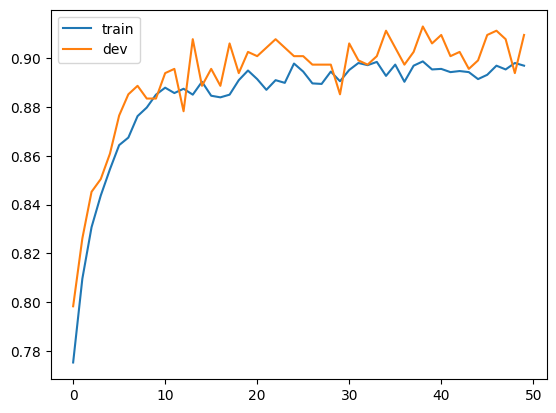

In [ ]:
# plot learning curves of model accuracy
plt.plot(history1.history['accuracy'], label='train')
plt.plot(history1.history['val_accuracy'], label='dev')
plt.legend()
plt.savefig('Model1_NoHiddenLayers.png')
plt.show()

In [ ]:
# evaluating the model
scores = model2.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

5/5 [==============================] - 0s 14ms/step - loss: 0.2243 - accuracy: 0.9272

Test result: 92.721 loss: 0.224


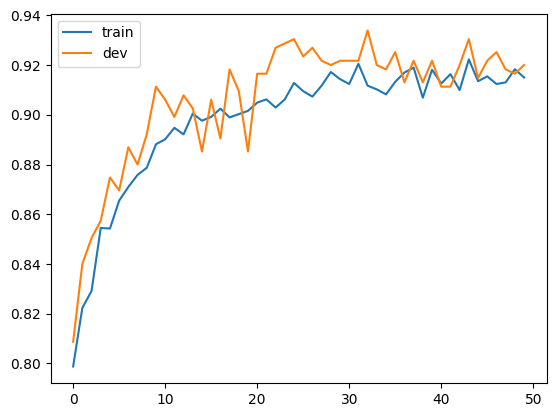

In [ ]:
# plot learning curves of model accuracy
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='dev')
plt.legend()
plt.savefig('Model2.png')
plt.show()

In [ ]:
# evaluating the model
scores = model3.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

5/5 [==============================] - 0s 11ms/step - loss: 0.2132 - accuracy: 0.9185

Test result: 91.854 loss: 0.213


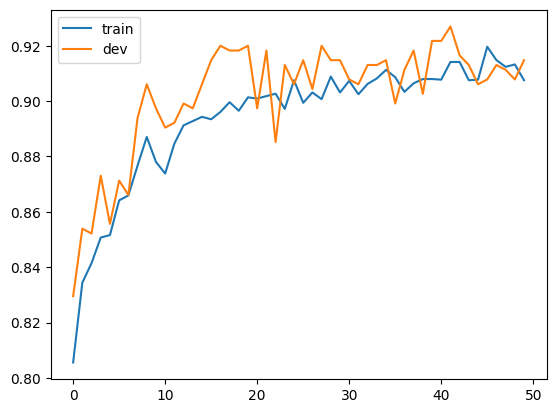

In [ ]:
# plot learning curves of model accuracy
plt.plot(history3.history['accuracy'], label='train')
plt.plot(history3.history['val_accuracy'], label='dev')
plt.legend()
plt.savefig('Model3.png')
plt.show()

In [ ]:
# evaluating the model
scores = model4.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

5/5 [==============================] - 0s 14ms/step - loss: 0.1664 - accuracy: 0.9272

Test result: 92.721 loss: 0.166


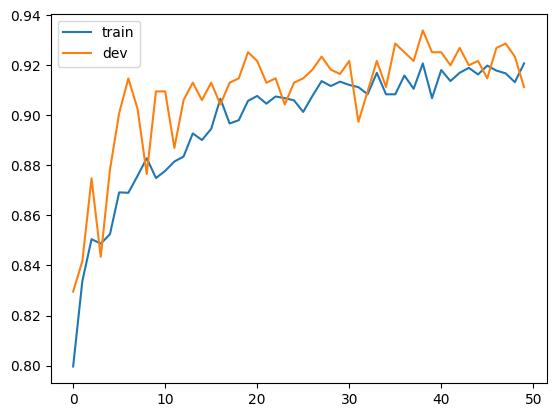

In [ ]:
# plot learning curves of model accuracy
plt.plot(history4.history['accuracy'], label='train')
plt.plot(history4.history['val_accuracy'], label='dev')
plt.legend()
plt.savefig('Model4.png')
plt.show()

In [ ]:
# evaluating the model
scores = model5.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

5/5 [==============================] - 0s 47ms/step - loss: 0.1018 - accuracy: 0.9653

Test result: 96.534 loss: 0.102


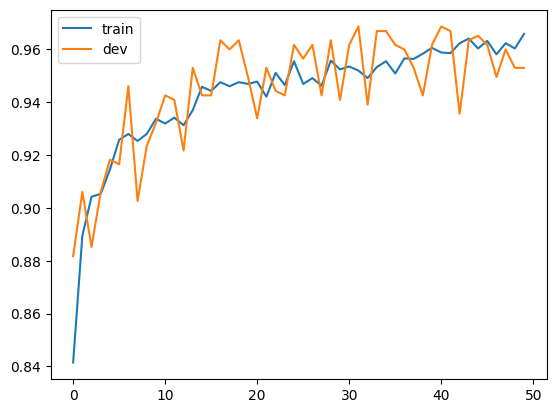

In [ ]:
# plot learning curves of model accuracy
plt.plot(history5.history['accuracy'], label='train')
plt.plot(history5.history['val_accuracy'], label='dev')
plt.legend()
plt.savefig('Model5.png')
plt.show()

In [ ]:
# evaluating the model
scores = model6.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

5/5 [==============================] - 0s 26ms/step - loss: 0.1068 - accuracy: 0.9653

Test result: 96.534 loss: 0.107


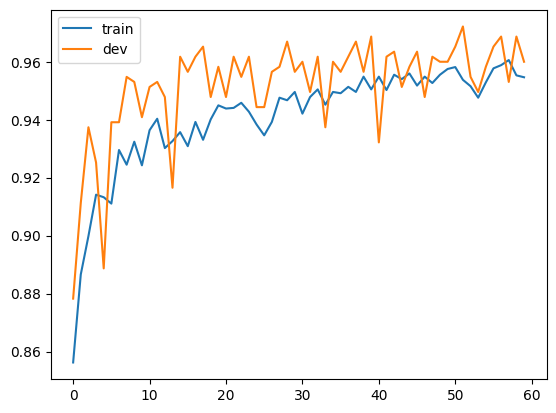

In [ ]:
# plot learning curves of model accuracy
plt.plot(history6.history['accuracy'], label='train')
plt.plot(history6.history['val_accuracy'], label='dev')
plt.legend()
plt.savefig('Model6.png')
plt.show()

In [ ]:
# evaluating the model
scores = model7.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

5/5 [==============================] - 1s 136ms/step - loss: 0.1006 - accuracy: 0.9619

Test result: 96.187 loss: 0.101


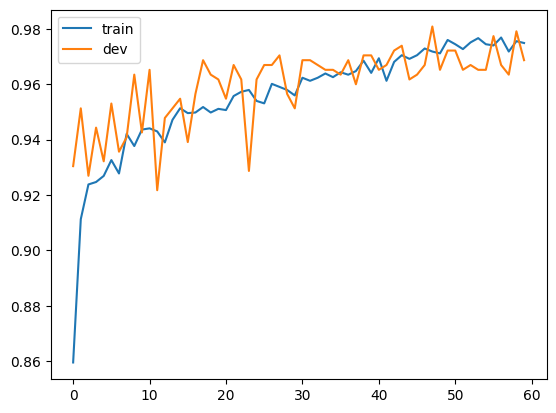

In [ ]:
# plot learning curves of model accuracy
plt.plot(history7.history['accuracy'], label='train')
plt.plot(history7.history['val_accuracy'], label='dev')
plt.legend()
plt.savefig('Model7.png')
plt.show()

In [ ]:
# evaluating the model
scores = model8.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

5/5 [==============================] - 0s 49ms/step - loss: 0.1153 - accuracy: 0.9549

Test result: 95.494 loss: 0.115


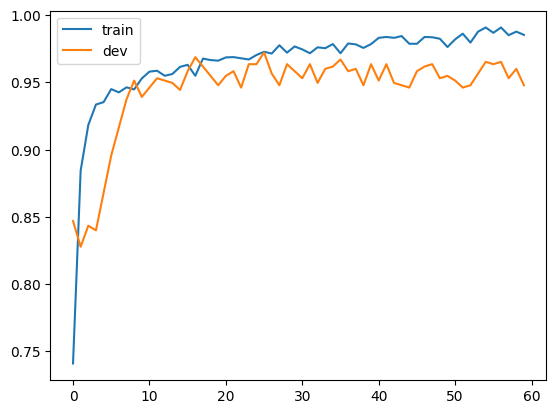

In [ ]:
# plot learning curves of model accuracy
plt.plot(history8.history['accuracy'], label='train')
plt.plot(history8.history['val_accuracy'], label='dev')
plt.legend()
plt.savefig('Model8.png')
plt.show()

In [ ]:
# evaluating the model
scores = model9.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

5/5 [==============================] - 1s 68ms/step - loss: 0.2005 - accuracy: 0.9515

Test result: 95.147 loss: 0.200


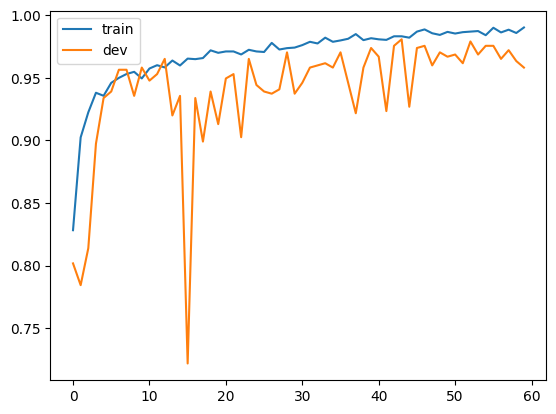

In [ ]:
# plot learning curves of model accuracy
plt.plot(history9.history['accuracy'], label='train')
plt.plot(history9.history['val_accuracy'], label='dev')
plt.legend()
plt.savefig('Model9.png')
plt.show()

In [ ]:
# evaluating the model
scores = model10.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

5/5 [==============================] - 1s 119ms/step - loss: 0.2074 - accuracy: 0.9463

Test result: 94.627 loss: 0.207


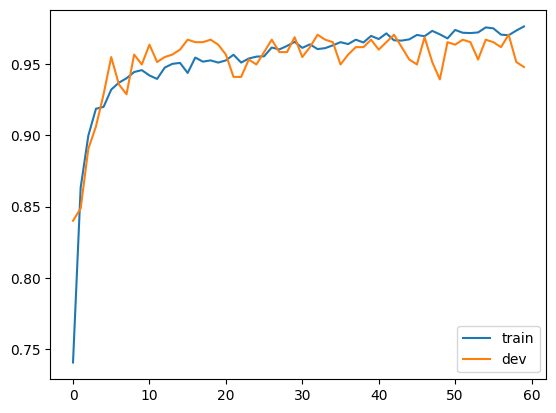

In [ ]:
# plot learning curves of model accuracy
plt.plot(history10.history['accuracy'], label='train')
plt.plot(history10.history['val_accuracy'], label='dev')
plt.legend()
plt.savefig('Model10.png')
plt.show()

In [ ]:
# evaluating the model
scores = model11.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

5/5 [==============================] - 0s 49ms/step - loss: 0.1095 - accuracy: 0.9653

Test result: 96.534 loss: 0.109


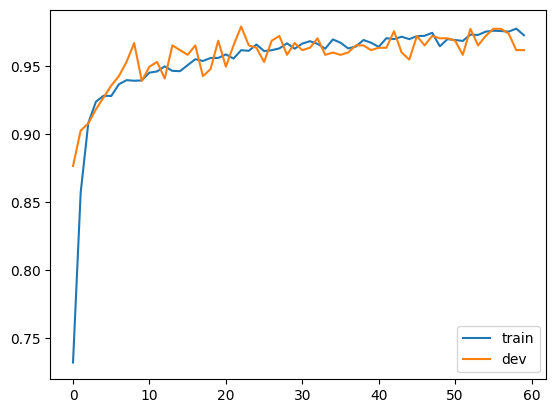

In [ ]:
# plot learning curves of model accuracy
plt.plot(history11.history['accuracy'], label='train')
plt.plot(history11.history['val_accuracy'], label='dev')
plt.legend()
plt.savefig('Model11.png')
plt.show()

In [ ]:
# evaluating the model
scores = model12.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

5/5 [==============================] - 0s 20ms/step - loss: 0.0903 - accuracy: 0.9723

Test result: 97.227 loss: 0.090


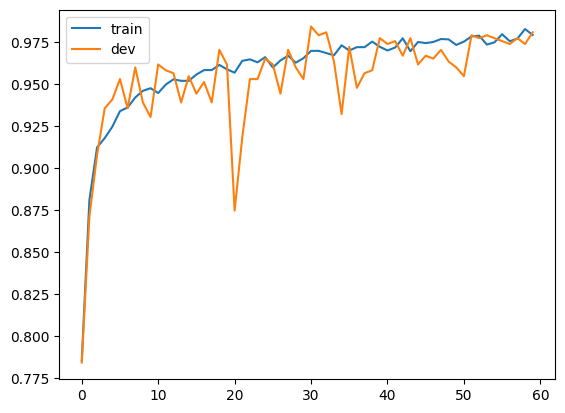

In [ ]:
# plot learning curves of model accuracy
plt.plot(history12.history['accuracy'], label='train')
plt.plot(history12.history['val_accuracy'], label='dev')
plt.legend()
plt.savefig('Model12.png')
plt.show()